## Classification of images into healthy and diseased classes

#### A computer vision based task of classifying images of chest x-rays into healthy and diseased classes. Healthy class consists of images that have been reported to have no pathologic finding. The diseased class consists of images that have been diagnosed of at least being an infiltration (a medical condition where a substance denser than air lingers in the parenchyma of the lungs).

In [75]:
%matplotlib inline
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import os
import seaborn as sns
from skimage.util import montage as montage2d
from skimage.io import imread
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from keras.applications.densenet import preprocess_input as dense_preprocess_input
import PIL
from PIL import Image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Input
from keras.layers import GlobalAveragePooling2D, multiply, LocallyConnected2D, Lambda
from keras.layers import BatchNormalization
import cv2
import tensorflow as tf
from sklearn.metrics import plot_confusion_matrix
from keras.models import load_model
from itertools import *
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from scipy import ndimage, misc

### Set path to load images

In [76]:
cd /media/obed/Backup/Files/MLDatasets/chest_xray

/media/obed/Backup/Files/MLDatasets/chest_xray


In [77]:
base_dir=os.path.join('.','sample','images')

In [78]:
base_dir

'./sample/images'

In [79]:
p_df=pd.read_csv('./Data_Entry_2017.csv')

In [80]:
p_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [81]:
image_paths={os.path.basename(x): x for x in glob(os.path.join('.','sample','images','*.png'))}

In [82]:
print('Scans found:', len(image_paths), ', Total Headers', p_df.shape[0])

Scans found: 102620 , Total Headers 112120


In [83]:
p_df.drop('Unnamed: 11', inplace=True, axis=1)

In [84]:
p_df['path']=p_df['Image Index'].map(image_paths.get)

In [85]:
p_df.dropna(subset=['path'], inplace=True)

In [86]:
#p_df[p_df['Image Index'] == '00020945_051.png']

### Identify the various diagnosis in the datasets

#### Eventhough there are 14 diseased classes, an image can be diagnosed of having more than one disease condition. Thus, the total of all disease conditions (including various combinations of the main disease classes) is 812

In [13]:
x=p_df['Finding Labels'].value_counts()

In [14]:
x

No Finding                                               55284
Infiltration                                              8846
Atelectasis                                               3894
Effusion                                                  3574
Nodule                                                    2474
                                                         ...  
Atelectasis|Cardiomegaly|Infiltration|Mass                   1
Emphysema|Infiltration|Mass|Nodule|Pleural_Thickening        1
Cardiomegaly|Fibrosis|Pneumothorax                           1
Emphysema|Mass|Pneumonia|Pneumothorax                        1
Effusion|Fibrosis|Mass|Cardiomegaly                          1
Name: Finding Labels, Length: 813, dtype: int64

In [15]:
num_labels=p_df['Finding Labels'].str.split('|', expand=True).stack().value_counts()

In [16]:
num_labels

No Finding            55284
Infiltration          18251
Effusion              12069
Atelectasis           10609
Nodule                 5809
Mass                   5229
Pneumothorax           4948
Consolidation          4136
Pleural_Thickening     3150
Cardiomegaly           2528
Emphysema              2283
Edema                  2003
Fibrosis               1527
Pneumonia              1308
Hernia                  201
dtype: int64

<AxesSubplot:title={'center':'Class data distribution'}>

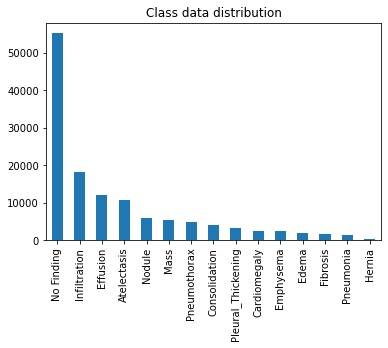

In [62]:
num_labels.plot.bar(rot=90, title='Class data distribution')

In [87]:
p_df['Healthy']=p_df['Finding Labels'].map(lambda x: 'No Finding' in x)

In [88]:
p_df['Diseased']=p_df['Finding Labels'].map(lambda x: 'Infiltration' in x)

In [89]:
sum(p_df['Healthy'])

55284

In [90]:
sum(p_df['Diseased'])

18251

## Examine distribution of images

In [186]:
#Image resolution

# loading the image 
img = PIL.Image.open("./sample/images/00014788_000.png") 
  
# fetching the dimensions 
wid, hgt = img.size 
  
# displaying the dimensions 
print(str(wid) + "x" + str(hgt))


1024x1024


In [91]:
p_df['Patient Age'] = np.clip(p_df['Patient Age'], 5, 100)
p_df['Patient Male'] = p_df['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')

In [22]:
p_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Healthy,Diseased,Patient Male
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,./sample/images/00000001_000.png,False,False,1.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,./sample/images/00000001_001.png,False,False,1.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,./sample/images/00000001_002.png,False,False,1.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,./sample/images/00000002_000.png,True,False,1.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,./sample/images/00000003_000.png,False,False,0.0


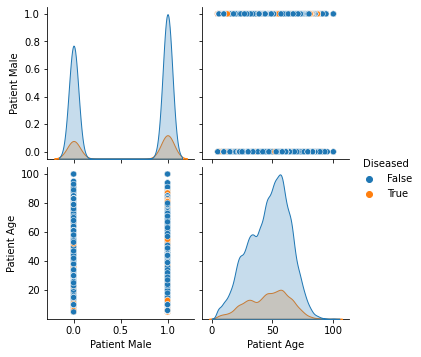

In [154]:
sns.pairplot(p_df[['Patient Male', 'Patient Age', 'Diseased']], hue='Diseased')

## Balance data distribution between healthy and disease class

In [92]:
positive = np.sum(p_df['Diseased']==True)//2
sampling_factor = 2
bal_df=p_df.groupby(['Patient Gender', 'Diseased']).apply(lambda x: x.sample(min(sampling_factor*positive, x.shape[0]), 
            replace = False)).reset_index(drop=True)

In [93]:
print(bal_df['Diseased'].value_counts())

False    36500
True     18251
Name: Diseased, dtype: int64


In [94]:
print(bal_df['Healthy'].value_counts())

False    30658
True     24093
Name: Healthy, dtype: int64


In [30]:
bal_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Healthy,Diseased,Patient Male
0,00007486_002.png,No Finding,2,7486,69,F,AP,2500,2048,0.168000,0.168000,./sample/images/00007486_002.png,True,False,0.0
1,00015495_009.png,Nodule,9,15495,55,F,PA,2500,2048,0.168000,0.168000,./sample/images/00015495_009.png,False,False,0.0
2,00022082_001.png,No Finding,1,22082,43,F,PA,2992,2991,0.143000,0.143000,./sample/images/00022082_001.png,True,False,0.0
3,00030581_000.png,No Finding,0,30581,54,F,PA,2021,2021,0.194308,0.194308,./sample/images/00030581_000.png,True,False,0.0
4,00007891_000.png,No Finding,0,7891,47,F,PA,2048,2500,0.168000,0.168000,./sample/images/00007891_000.png,True,False,0.0


In [95]:
bal_df = bal_df[(bal_df.Healthy == True) | (bal_df.Diseased == True)]

In [96]:
bal_df.shape

(42344, 15)

In [97]:
bal_df.Diseased.value_counts()

False    24093
True     18251
Name: Diseased, dtype: int64

In [34]:
bal_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Healthy,Diseased,Patient Male
0,00007486_002.png,No Finding,2,7486,69,F,AP,2500,2048,0.168000,0.168000,./sample/images/00007486_002.png,True,False,0.0
2,00022082_001.png,No Finding,1,22082,43,F,PA,2992,2991,0.143000,0.143000,./sample/images/00022082_001.png,True,False,0.0
3,00030581_000.png,No Finding,0,30581,54,F,PA,2021,2021,0.194308,0.194308,./sample/images/00030581_000.png,True,False,0.0
4,00007891_000.png,No Finding,0,7891,47,F,PA,2048,2500,0.168000,0.168000,./sample/images/00007891_000.png,True,False,0.0
5,00015566_000.png,No Finding,0,15566,31,F,PA,2500,2048,0.168000,0.168000,./sample/images/00015566_000.png,True,False,0.0
8,00029304_001.png,No Finding,1,29304,35,F,AP,3056,2544,0.139000,0.139000,./sample/images/00029304_001.png,True,False,0.0
11,00010068_000.png,No Finding,0,10068,28,F,PA,2048,2500,0.168000,0.168000,./sample/images/00010068_000.png,True,False,0.0
12,00022429_002.png,No Finding,2,22429,9,F,AP,3056,2544,0.139000,0.139000,./sample/images/00022429_002.png,True,False,0.0
14,00030665_000.png,No Finding,0,30665,76,F,PA,2021,2020,0.194311,0.194311,./sample/images/00030665_000.png,True,False,0.0
15,00015160_004.png,No Finding,4,15160,38,F,PA,2500,2048,0.168000,0.168000,./sample/images/00015160_004.png,True,False,0.0


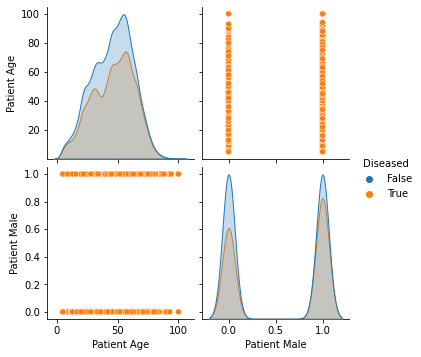

In [162]:
sns.pairplot(bal_df[['Patient Age','Patient Male','Diseased']], hue='Diseased')

## Split data into test and train set

In [98]:
df_train, valid_test_df = train_test_split(bal_df, test_size=0.3,random_state=40,stratify=bal_df[['Diseased', 'Patient Gender']])
df_valid, df_test = train_test_split(valid_test_df, test_size=0.4, random_state=40, stratify = valid_test_df[['Diseased', 'Patient Gender']])

In [99]:
print('train', df_train.shape[0], 'validation', df_valid.shape[0], 'test', df_test.shape[0])
print('train', df_train['Diseased'].value_counts())
print('test', df_test['Diseased'].value_counts())
df_train.sample(1)

train 29640 validation 7622 test 5082
train False    16865
True     12775
Name: Diseased, dtype: int64
test False    2891
True     2191
Name: Diseased, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Healthy,Diseased,Patient Male
39165,00005066_035.png,No Finding,35,5066,53,M,AP,2500,2048,0.168,0.168,./sample/images/00005066_035.png,True,False,1.0


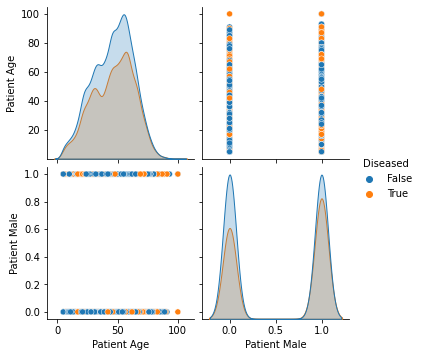

In [165]:
sns.pairplot(df_train[['Patient Age','Patient Male','Diseased']], hue='Diseased')

## Balance distribution in training set

In [100]:
train_df_bal = df_train.groupby(['Diseased']).apply(lambda x: x.sample(12700, replace = True)).reset_index(drop = True)
print('New Data Size:', train_df_bal.shape[0], 'Old Size:', df_train.shape[0])

New Data Size: 25400 Old Size: 29640


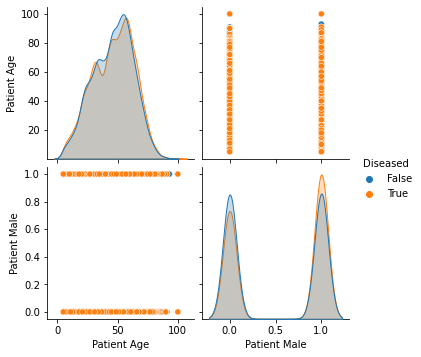

In [167]:
sns.pairplot(train_df_bal[['Patient Age','Patient Male','Diseased']], hue='Diseased')

## Load images

In [109]:
#Specify target image size
IMG_SIZE=(224,224)#densenet
#IMG_SIZE=(512,512)#vgg16

#Specify the preprocessing function for the base pretrained model
PREPROCESS=dense_preprocess_input

In [110]:
#Data augmentation for training
train_img_gen = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip=False, 
                              vertical_flip=False, 
                              height_shift_range=0.01, 
                              width_shift_range=0.1, 
                              rotation_range=315, 
                              shear_range=0.01,
                              fill_mode='nearest',
                              zoom_range=0.125,
                              #rescale=1./255)#model trained from scratch                          
                              preprocessing_function=PREPROCESS)#transfer learning

In [111]:
#Image data generator for test set
img_gen = ImageDataGenerator(preprocessing_function=PREPROCESS)
#img_gen = ImageDataGenerator(rescale=1./255)

In [112]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    df_gen = img_data_gen.flow_from_dataframe(in_df,
                                              x_col=path_col,
                                              y_col=y_col,
                                              shuffle=True,
                                            class_mode = 'raw',
                                            **dflow_args)
    return df_gen

In [113]:
gen_train = flow_from_dataframe(train_img_gen, train_df_bal, 
                             path_col = 'path',
                            y_col = 'Diseased', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            #color_mode = 'grayscale',#from scratch model
                            batch_size = 20)

gen_valid = flow_from_dataframe(img_gen, df_valid, 
                             path_col = 'path',
                            y_col = 'Diseased',  
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            #color_mode='grayscale',#from scratch model
                            batch_size = 256) 
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(img_gen, 
                               df_valid, 
                             path_col = 'path',
                            y_col = 'Diseased', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            #color_mode='grayscale', #from scratch model
                            batch_size = 400)) # one big batch
# used a fixed dataset for final evaluation
final_test_X, final_test_Y = next(flow_from_dataframe(img_gen, 
                               df_test, 
                             path_col = 'path',
                            y_col = 'Diseased', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            #color_mode = 'grayscale', #from scratch model
                            batch_size = 400)) # one big batch

Found 25400 validated image filenames.
Found 7622 validated image filenames.
Found 7622 validated image filenames.
Found 5082 validated image filenames.


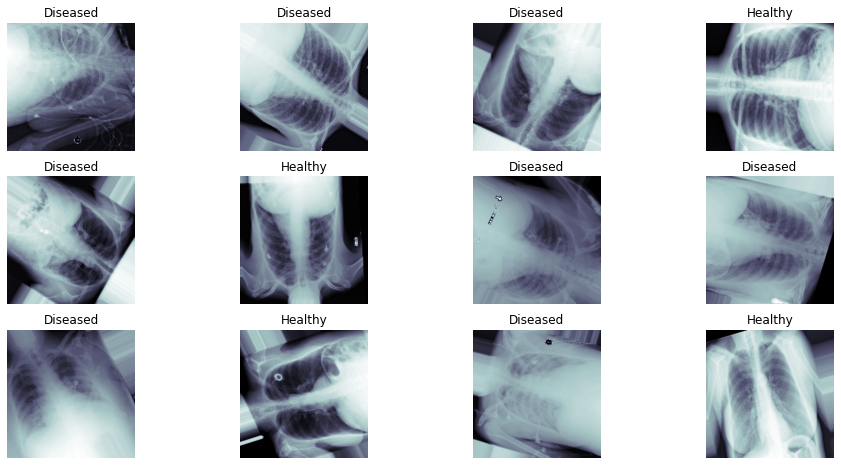

In [173]:
#Visualizing sample of training data 
t_x, t_y = next(gen_train)
fig, t_axs = plt.subplots(3, 4, figsize = (16, 8))
for (t_x, t_y, t_ax) in zip(t_x, t_y, t_axs.flatten()):
    t_ax.imshow(t_x[:,:,0], cmap = 'bone')#, vmin = -127, vmax = 127)
    t_ax.set_title('%s' % ('Diseased' if t_y>0.5 else 'Healthy'))
    t_ax.axis('off')

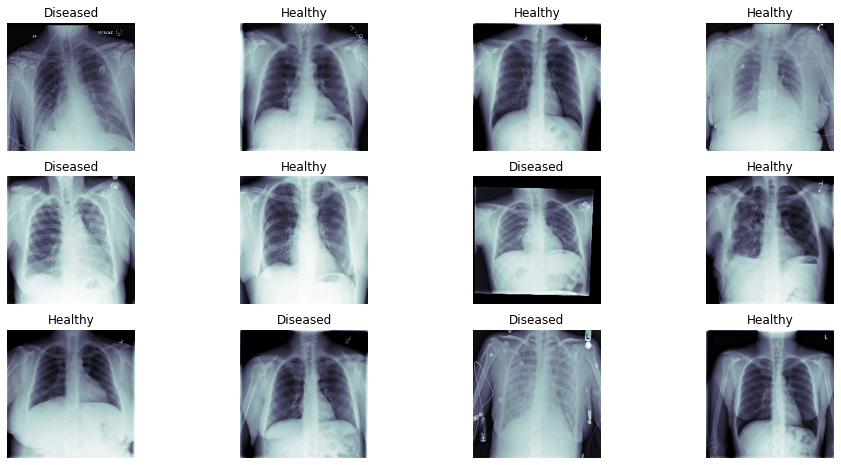

In [174]:
#Visualizing sample of validation data
v_x, v_y = next(gen_valid)
fig, v_axs = plt.subplots(3, 4, figsize = (16, 8))
for (d_x, d_y, d_ax) in zip(v_x, v_y, v_axs.flatten()):
    d_ax.imshow(d_x[:,:,0], cmap = 'bone')#, vmin = -127, vmax = 127)
    d_ax.set_title('%s' % ('Diseased' if d_y>0.5 else 'Healthy'))
    d_ax.axis('off')

## Model Training

#### Baseline model is based on the architecture of VGG11. 

In [114]:
#Function to train a simple model
new_input=(224,224,1)
def simple_model():

    model = Sequential()

    model.add(Conv2D(64, kernel_size = (3, 3), activation='relu', input_shape=new_input))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(32, kernel_size = (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(32, kernel_size = (3, 3), activation='relu'))
    model.add(Conv2D(32, kernel_size = (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size = (3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size = (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size = (3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size = (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(96, activation='relu'))
    model.add(Dense(96, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [115]:
#create an instance of simple model
x_model=simple_model()

In [117]:
x_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 64)      640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)       

In [116]:
#Train model
checkpoint = ModelCheckpoint("best_simple_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1)

history_simple=x_model.fit(x=gen_train, validation_data=(test_X,test_Y), 
                            validation_batch_size=15, steps_per_epoch=50, epochs=10, verbose=2,
                            callbacks=[checkpoint])

Epoch 1/10

Epoch 00001: val_accuracy improved from -inf to 0.44750, saving model to best_simple_model.hdf5
50/50 - 72s - loss: 0.6939 - accuracy: 0.4940 - val_loss: 0.6944 - val_accuracy: 0.4475
Epoch 2/10

Epoch 00002: val_accuracy did not improve from 0.44750
50/50 - 70s - loss: 0.6932 - accuracy: 0.5120 - val_loss: 0.6948 - val_accuracy: 0.4475
Epoch 3/10

Epoch 00003: val_accuracy did not improve from 0.44750
50/50 - 69s - loss: 0.6931 - accuracy: 0.5130 - val_loss: 0.6950 - val_accuracy: 0.4475
Epoch 4/10

Epoch 00004: val_accuracy did not improve from 0.44750
50/50 - 69s - loss: 0.6930 - accuracy: 0.5120 - val_loss: 0.6955 - val_accuracy: 0.4475
Epoch 5/10

Epoch 00005: val_accuracy did not improve from 0.44750
50/50 - 70s - loss: 0.6910 - accuracy: 0.5410 - val_loss: 0.6998 - val_accuracy: 0.4475
Epoch 6/10

Epoch 00006: val_accuracy did not improve from 0.44750
50/50 - 71s - loss: 0.6928 - accuracy: 0.5190 - val_loss: 0.6992 - val_accuracy: 0.4475
Epoch 7/10

Epoch 00007: val_

## Transfer learning

### VGG16

#### Imported the VGG 16 model trained on Imagenet. Used the model as an integrated feature extractor. That is, the layers of the pre trained model were frozen and were integrated into a new model which used learned features for classification. The model was fine tuned with 400 images per epoch for 10 epochs. The best validation accuracy score after training was 62.5% and that was on the 5th and 6th epoch. 

In [37]:
#Import VGG16 model
model_vgg16 = tf.keras.applications.vgg16.VGG16()

In [38]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [39]:
#load model and specify a new input shape for images
new_input=Input(shape=(512,512,3))
v_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_tensor=new_input, pooling='avg')

In [40]:
v_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [41]:
dropout_layer = Dropout(0.5)(v_model.layers[-1].output)
bn_layer = BatchNormalization(name='bn_features')(dropout_layer)
dense_layer=(Dense(128, activation = 'relu'))(bn_layer)
output_layer = Dense(1, activation = 'sigmoid')(dense_layer)

model_inf = Model(inputs = v_model.inputs, outputs = [output_layer], name = 'xray_model')

In [42]:
#freeze weights of pretrained model
for layer in v_model.layers:
    layer.trainable=False

In [43]:
model_inf.summary()

Model: "xray_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0

### Fit VGG16

In [45]:
model_inf.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
history=model_inf.fit(x=gen_train, validation_data=(test_X,test_Y), validation_batch_size=10, steps_per_epoch=20, epochs=10, verbose=2)

Epoch 1/10
20/20 - 873s - loss: 0.8253 - accuracy: 0.4867 - val_loss: 0.6948 - val_accuracy: 0.5775
Epoch 2/10
20/20 - 871s - loss: 0.7534 - accuracy: 0.4933 - val_loss: 0.6834 - val_accuracy: 0.5850
Epoch 3/10
20/20 - 872s - loss: 0.7392 - accuracy: 0.5767 - val_loss: 0.6782 - val_accuracy: 0.6000
Epoch 4/10
20/20 - 872s - loss: 0.7808 - accuracy: 0.5233 - val_loss: 0.6719 - val_accuracy: 0.6175
Epoch 5/10
20/20 - 872s - loss: 0.7553 - accuracy: 0.5200 - val_loss: 0.6677 - val_accuracy: 0.6250
Epoch 6/10
20/20 - 877s - loss: 0.7777 - accuracy: 0.5133 - val_loss: 0.6650 - val_accuracy: 0.6250
Epoch 7/10
20/20 - 873s - loss: 0.7207 - accuracy: 0.5667 - val_loss: 0.6643 - val_accuracy: 0.6200
Epoch 8/10
20/20 - 873s - loss: 0.7457 - accuracy: 0.5600 - val_loss: 0.6631 - val_accuracy: 0.6125
Epoch 9/10
20/20 - 874s - loss: 0.7427 - accuracy: 0.5300 - val_loss: 0.6629 - val_accuracy: 0.6050
Epoch 10/10
20/20 - 873s - loss: 0.7326 - accuracy: 0.5933 - val_loss: 0.6619 - val_accuracy: 0.6050

In [85]:
#Save attention model with 150 steps per epoch
model_inf.save("infiltration.h5")
print("Saved model to disk")

Saved model to disk


### DENSENET201

#### Imported densenet 201 model that was trained on the Imagenet task. Integrated the layers of the model into a fully connected output layer with a sigmoid activation function. The layers of the pretrained models were trained in concert with the new output layer but weights were initialised with pretrained imagenet weights.

In [96]:
model_dense=tf.keras.applications.DenseNet201()

In [91]:
model_dense.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

                                                                 conv5_block6_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block7_0_bn (BatchNormali (None, 7, 7, 1088)   4352        conv5_block6_concat[0][0]        
__________________________________________________________________________________________________
conv5_block7_0_relu (Activation (None, 7, 7, 1088)   0           conv5_block7_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_block7_1_conv (Conv2D)    (None, 7, 7, 128)    139264      conv5_block7_0_relu[0][0]        
__________________________________________________________________________________________________
conv5_block7_1_bn (BatchNormali (None, 7, 7, 128)    512         conv5_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_bloc

In [40]:
#Define new model to integrate with densenet201
def create_model():
    new_input = Input(shape=(224,224,3))
    densed_model=tf.keras.applications.DenseNet201(include_top=False,weights='imagenet',input_tensor=new_input,pooling='avg')
    output_layer = Dense(1, activation = 'sigmoid')(densed_model.layers[-1].output)
    model = Model(inputs = densed_model.inputs, outputs = [output_layer], name = 'dense_model')
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [41]:
densenet_model = create_model()

In [99]:
densenet_model.summary()

Model: "dense_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

conv5_block21_2_conv (Conv2D)   (None, 7, 7, 32)     36864       conv5_block21_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block21_concat (Concatena (None, 7, 7, 1568)   0           conv5_block20_concat[0][0]       
                                                                 conv5_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block22_0_bn (BatchNormal (None, 7, 7, 1568)   6272        conv5_block21_concat[0][0]       
__________________________________________________________________________________________________
conv5_block22_0_relu (Activatio (None, 7, 7, 1568)   0           conv5_block22_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block22_1_conv (Conv2D)   (None, 7, 7, 128)    200704      conv5_block22_0_relu[0][0]       
__________

In [106]:
densenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [107]:
#Train model on 10000 images per epoch. Though the best validation score achieved was 73.50%,
#the associated weight was not saved since a model checkpoint was not included in the code during training.
#Thus, the saved model which is at the end of the training had a validation accuracy of 65.00% 
history=densenet_model.fit(x=gen_train, validation_data=(test_X,test_Y), validation_batch_size=15, steps_per_epoch=500, epochs=25, verbose=2)

Epoch 1/25
500/500 - 6632s - loss: 0.6589 - accuracy: 0.6232 - val_loss: 0.5765 - val_accuracy: 0.6925
Epoch 2/25
500/500 - 6551s - loss: 0.6345 - accuracy: 0.6486 - val_loss: 0.5676 - val_accuracy: 0.7150
Epoch 3/25
500/500 - 6550s - loss: 0.6183 - accuracy: 0.6569 - val_loss: 0.6330 - val_accuracy: 0.6525
Epoch 4/25
500/500 - 6547s - loss: 0.6068 - accuracy: 0.6668 - val_loss: 0.6289 - val_accuracy: 0.6775
Epoch 5/25
500/500 - 6543s - loss: 0.5974 - accuracy: 0.6773 - val_loss: 0.5769 - val_accuracy: 0.7100
Epoch 6/25
500/500 - 6540s - loss: 0.5970 - accuracy: 0.6797 - val_loss: 0.5948 - val_accuracy: 0.6925
Epoch 7/25
500/500 - 6545s - loss: 0.5864 - accuracy: 0.6861 - val_loss: 0.5919 - val_accuracy: 0.7050
Epoch 8/25
500/500 - 6548s - loss: 0.5904 - accuracy: 0.6820 - val_loss: 0.7081 - val_accuracy: 0.5250
Epoch 9/25
500/500 - 6554s - loss: 0.5837 - accuracy: 0.6893 - val_loss: 0.6277 - val_accuracy: 0.6825
Epoch 10/25
500/500 - 6553s - loss: 0.5844 - accuracy: 0.6943 - val_loss:

In [108]:
#Save densenet model
densenet_model.save("densenet.h5")
print("Saved model to disk")

Saved model to disk


In [43]:
dense_model=load_model("densenet.h5")

In [113]:
#An accuracy of 59.50% obtained when model was evaluated on held out test data. This was expected
#Since the model was not saved when the best loss value was achived
dense_score = dense_model.evaluate(final_test_X, final_test_Y, steps=200, verbose=1)

200/300 [===================>..........] - 56s 278ms/step - loss: 0.6671 - accuracy: 0.5950


### Visualization of model performance as training progresses of DenseNet201

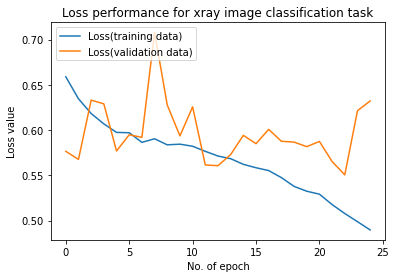

In [114]:
#Plot history: Loss (binary crossentropy)
plt.plot(history.history['loss'],
        label='Loss(training data)')
plt.plot(history.history['val_loss'],
        label='Loss(validation data)')
plt.title('Loss performance for xray image classification task')
plt.ylabel('Loss value')
plt.xlabel('No. of epoch')
plt.legend(loc='upper left')
plt.show()

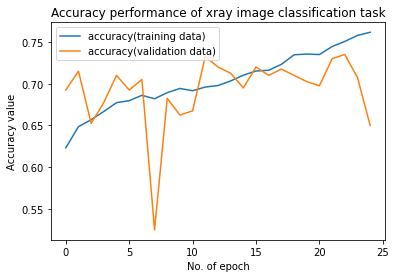

In [117]:
#Plot history: Accuracy
plt.plot(history.history['accuracy'], label='accuracy(training data)')
plt.plot(history.history['val_accuracy'], label ='accuracy(validation data)')
plt.title('Accuracy performance of xray image classification task')
plt.ylabel('Accuracy value')
plt.xlabel('No. of epoch')
plt.legend(loc='upper left')
plt.show()


In [91]:
#Train the model for another 30 epochs with a modelcheckpoint included. Also, increased training data
#from 17000 to 25000. Best score 72%
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1)

history2=dense_model.fit(x=gen_train, validation_data=(test_X,test_Y), 
                            validation_batch_size=15, steps_per_epoch=500, epochs=30, verbose=2,
                            callbacks=[checkpoint])

Epoch 1/30

Epoch 00001: val_accuracy improved from -inf to 0.69500, saving model to best_model.hdf5
500/500 - 6791s - loss: 0.5860 - accuracy: 0.6919 - val_loss: 0.5922 - val_accuracy: 0.6950
Epoch 2/30

Epoch 00002: val_accuracy did not improve from 0.69500
500/500 - 6724s - loss: 0.5728 - accuracy: 0.7013 - val_loss: 0.5755 - val_accuracy: 0.6950
Epoch 3/30

Epoch 00003: val_accuracy improved from 0.69500 to 0.71250, saving model to best_model.hdf5
500/500 - 6708s - loss: 0.5686 - accuracy: 0.7087 - val_loss: 0.5714 - val_accuracy: 0.7125
Epoch 4/30

Epoch 00004: val_accuracy did not improve from 0.71250
500/500 - 6708s - loss: 0.5659 - accuracy: 0.7082 - val_loss: 0.5926 - val_accuracy: 0.7075
Epoch 5/30

Epoch 00005: val_accuracy did not improve from 0.71250
500/500 - 6697s - loss: 0.5687 - accuracy: 0.7086 - val_loss: 0.6093 - val_accuracy: 0.6750
Epoch 6/30

Epoch 00006: val_accuracy did not improve from 0.71250
500/500 - 6697s - loss: 0.5608 - accuracy: 0.7136 - val_loss: 0.620

### Visualization of model performance

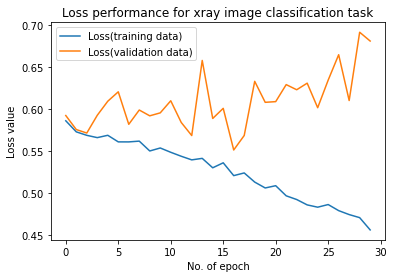

In [93]:
#Plot history: Loss (binary crossentropy)
plt.plot(history2.history['loss'],
        label='Loss(training data)')
plt.plot(history2.history['val_loss'],
        label='Loss(validation data)')
plt.title('Loss performance for xray image classification task')
plt.ylabel('Loss value')
plt.xlabel('No. of epoch')
plt.legend(loc='upper left')
plt.show()

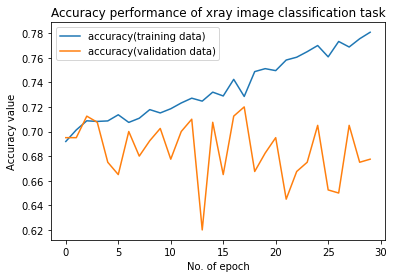

In [94]:
#Plot history: Accuracy
plt.plot(history2.history['accuracy'], label='accuracy(training data)')
plt.plot(history2.history['val_accuracy'], label ='accuracy(validation data)')
plt.title('Accuracy performance of xray image classification task')
plt.ylabel('Accuracy value')
plt.xlabel('No. of epoch')
plt.legend(loc='upper left')
plt.show()

In [42]:
model_best=create_model()

In [43]:
model_best.load_weights('best_model.hdf5')

In [175]:
score = model_best.evaluate(final_test_X, final_test_Y, steps=200, verbose=1)

200/200 [==============================] - 54s 271ms/step - loss: 0.5826 - accuracy: 0.7175


In [179]:
#Predictions on held out test data
predictions = model_best.predict(final_test_X, batch_size=10, verbose=True)

40/40 [==============================] - 47s 1s/step


              precision    recall  f1-score   support

    Diseased       0.74      0.79      0.76       230
     Healthy       0.69      0.62      0.65       170

    accuracy                           0.72       400
   macro avg       0.71      0.70      0.71       400
weighted avg       0.72      0.72      0.72       400



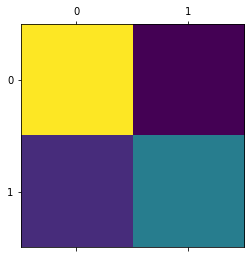

In [180]:
plt.matshow(confusion_matrix(final_test_Y, predictions>0.5))
print(classification_report(final_test_Y, predictions>0.5, target_names = ['Diseased', 'Healthy']))

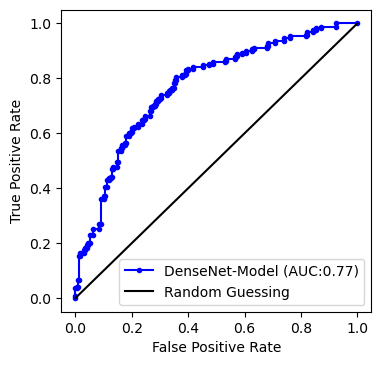

In [181]:
test_fpos, test_tpos, _ = roc_curve(final_test_Y, predictions)
fig, ax1 = plt.subplots(1,1, figsize = (4, 4), dpi = 100)
ax1.plot(test_fpos, test_tpos, 'b.-', label = 'DenseNet-Model (AUC:%2.2f)' % roc_auc_score(final_test_Y, predictions))
ax1.plot(test_fpos, test_fpos, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('test_roc.pdf')